The following are some tests using the robust synthetic control method presented in http://peerunreviewed.blogspot.com/2019/11/a-short-tutorial-on-robust-synthetic.html
(code here: https://github.com/jehangiramjad/tslib) 
in order to help better understand it 

In [44]:
# import relevant libraries and files 
# NOTE: the RobustSyntheticControl function is from a file made by the orginal researchers
# and I think you will need to download it from their github page (link above)
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
import copy

from tslib.src import tsUtils
from tslib.src.synthcontrol.syntheticControl import RobustSyntheticControl
from tslib.tests import testdata

from sklearn.impute import SimpleImputer
import datetime as dt

First create a few functions that will work with different data sets

In [95]:
# A fucntion to toggle wether or not you display the current cell
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>
        
        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [94]:
# calculates and graphs singular values to analyze data
def check_vals(input_data):
    U, s, Vt = np.linalg.svd(input_data)
    plt.figure()
    plt.plot(s)
    plt.grid()
    plt.xlabel("singular values")
    plt.ylabel("energy")
    plt.show()
    
# replaces missing values using sklearn's simple imputer 
# method can be "mean", "median", "mode", etc. 
def missing_vals(method, input_data):
    my_imputer = SimpleImputer(method)
    imputed_data = pd.DataFrame(my_imputer.fit_transform(input_data))
    
    #imputer removes column names so you need to put them back
    imputed_data.columns = input_data.columns
    
    return imputed_data

# And finally, a function to plot the results found with RobustSyntheticControl()
# original data is the column from the original set you want to compare results with
# model_fit is the synthetic model fit onto the training period 
# predictions are the counterfactual result, the predictions for the test period
def plot_synth(original_data, model_fit, predictions, title, y_label):
    dates = list(original_data.index)
    spacing = 20
    fig, ax = plt.subplots(1,1, figsize = (15,5))
    ax.set_xticks(np.arange(0,len(dates),spacing))
    ax.set_xticklabels(dates[::20], rotation = 45)

    plt.plot(original_data, label = 'actual')
    plt.plot(model_fit, label = "fitted model")
    plt.plot(predictions, label = "counterfactual")
    plt.axvline(x = predictions.index[0], color = 'k', linestyle = "--", linewidth = 2)
    plt.xlabel('Date')
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

hide_toggle()
    

## NY Phase 3 Re-opening

NY city committed to phase 3 of its reopening plan on July 6 2020. Synthetic control might be useful to see if this led to an uptick of cases that could have been prevented by delaying or changing the details of their opening process. 

To predict results I will first use data from Italy which has had similar case numbers throughout the course of the pandemic 

The data sources I used for this are here:
https://www1.nyc.gov/site/doh/covid/covid-19-data.page

https://www.ecdc.europa.eu/en/publications-data/data-national-14-day-notification-rate-covid-19

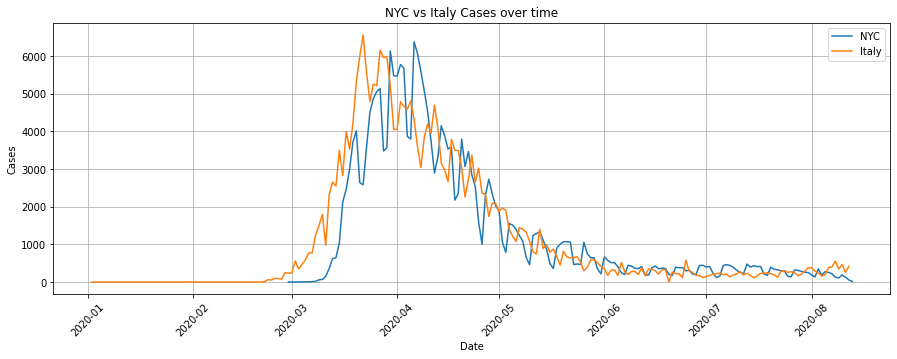

In [79]:
# first take a look at how similar their case number are
nyc = pd.read_csv("daily_nyc.csv", index_col = "DATE_OF_INTEREST", parse_dates=True)
italy = pd.read_csv("daily_worldwide.csv", index_col="date", parse_dates=True)

italy = italy.loc[(italy.country == "Italy") & (italy.indicator == "confirmed cases")]
nyc_cases = nyc.Cases
italy_cases = italy.daily_count

plt.figure(figsize = (15,5))
plt.plot(nyc_cases, label = "NYC")
plt.plot(italy_cases, label = "Italy")
plt.title("NYC vs Italy Cases over time")
plt.ylabel("Cases")
plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.grid()
plt.legend()
plt.show()

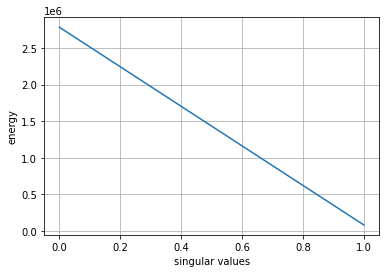

In [80]:
# Now use Synthetic control to see what the case numbers could have looked like

compared = pd.concat([nyc_cases, italy_cases], axis = 1)
compared = compared.fillna(0)
compared.columns = ["NYC", "Italy"]
compared.index = compared.index.strftime("%m-%d-%Y")

# Change our data set so that it uses total cases instead of daily 
def sum_totals(column):
    total = 0
    for i in column.index:
        total += column.loc[i]
        column.loc[i] = total
        
compared.apply(sum_totals, axis = "index")

# split into a train and test period
train_start = "03-01-2020"
train_end = "07-06-2020"
test_end = compared.index[-1]

train = compared.loc[train_start:train_end]
test = compared.loc[train_end:test_end]

#check to see if the training matrix is low run
check_vals(train)

#The graph looks strange because there are only two singular values, but they both seem relevant

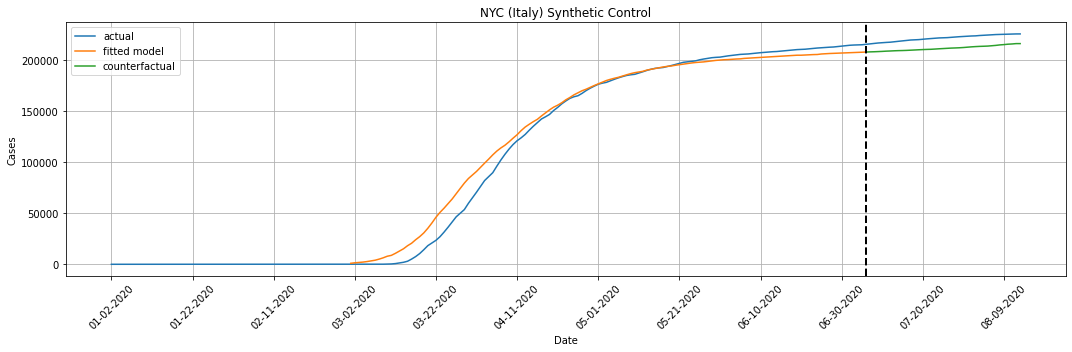

In [81]:
# So lets use both singular values and see what happens 
singvals = 2
others = list(train.columns)
others.remove("NYC")
rmodel = RobustSyntheticControl("NYC", singvals, len(train), probObservation = 1.0,
                modelType = 'svd', svdMethod = 'numpy', otherSeriesKeysArray = others)
rmodel.fit(train)
#Not quite sure what this does but it seems important
denoisedDF = rmodel.model.denoisedDF()

#multiply by modeled weights to get predictions
predictions = []
#predictions = np.dot(test["Italy"], rmodel.model.weights)
predictions = test["Italy"] * rmodel.model.weights[0]
predictions = pd.Series(predictions, index = test.index)
#get actual results
actual = compared.NYC

#fit the model on the training data to see how accurate it is
#model_fit = np.dot(train["Italy"], rmodel.model.weights)
model_fit = train["Italy"] * rmodel.model.weights[0]
model_fit = pd.Series(model_fit, index = train.index)

# and graph to see results
plot_synth(actual, model_fit, predictions, "NYC (Italy) Synthetic Control", "Cases")

This is a strange result. The fitted model seems fairly accurate, however it undervalues case numbers well before NY's date of reopening. This may be because Italy hit its peaks and recovered before New York did. I think this does clearly show that Italy is having more success with their re-opening process, for whatever reason. However, it's possible that the method needs more data to compare to. Its also may be more valuable to use data that isnt very similar to the original. This may give more interesting results. 

### NYC vs Other States

With that in mind I will add in data from a few other states and see how that works.
Ill use California, Massachussets, and Florida

Also, this time I'm going to use a total case count instead of a daily count because I think that will make things easier to look at.

The data will come from the Covid Tracking Project
https://covidtracking.com/data

In [82]:
# creating the data frame for cases from California, Mass, and Florida
other_states = pd.read_csv("covid_tracker_daily.csv", index_col = "date", parse_dates = True)
other_states.index = other_states.index.strftime("%m-%d-%Y")
california = other_states.loc[other_states.state == "CA"]
mass = other_states.loc[other_states.state == "MA"]
florida = other_states.loc[other_states.state == "FL"]

cali_case = california.positive
mass_case = mass.positive
flor_case = florida.positive
others = pd.concat([cali_case, mass_case, flor_case], axis = 1)
others = others.fillna(0)
others.columns = ["California", "Massachusetts", "Florida"]
others = others.iloc[::-1]


                 NYC     Italy  California  Massachusetts   Florida
01-02-2020       0.0       0.0         0.0            0.0       0.0
01-03-2020       0.0       0.0         0.0            0.0       0.0
01-04-2020       0.0       0.0         0.0            0.0       0.0
01-05-2020       0.0       0.0         0.0            0.0       0.0
01-06-2020       0.0       0.0         0.0            0.0       0.0
...              ...       ...         ...            ...       ...
08-09-2020  225655.0  250251.0    554160.0       121040.0  532806.0
08-10-2020  225842.0  250714.0    561911.0       121315.0  536961.0
08-11-2020  225970.0  250973.0    574411.0       121707.0  542792.0
08-12-2020  226026.0  251385.0    586056.0       122000.0  550901.0
08-13-2020  226042.0  251385.0    593141.0       122319.0  557137.0

[225 rows x 5 columns]


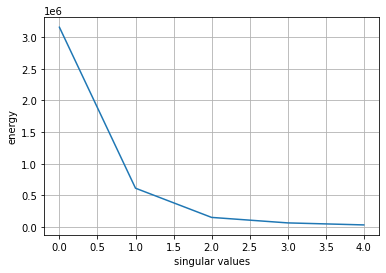

In [83]:
# Now combine the sources and apply the method
nyc_others = pd.concat([compared,others], axis = 1)
nyc_others = nyc_others.fillna(0)
nyc_others = nyc_others.iloc[:-2]

#split into train and test again
train2 = nyc_others.loc[train_start:train_end]
test2 = nyc_others.loc[train_end:test_end]

#check to see if the training matrix is low run
check_vals(train2)

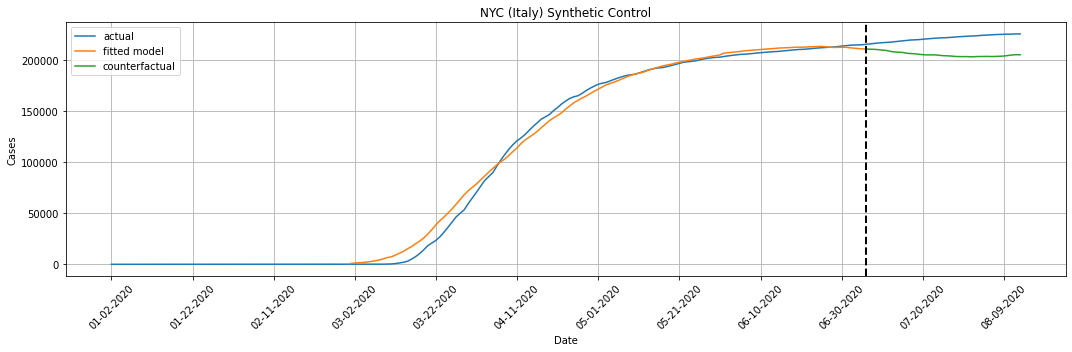

In [101]:
# So try 3 singular values and see what happens 
singvals = 3
otherArray = list(train2.columns)
otherArray.remove("NYC")
rmodel = RobustSyntheticControl("NYC", singvals, len(train2), probObservation = 1.0,
                modelType = 'svd', svdMethod = 'numpy', otherSeriesKeysArray = otherArray)
rmodel.fit(train2)
#Not quite sure what this does but it seems important
denoisedDF = rmodel.model.denoisedDF()

#multiply by modeled weights to get predictions
predictions = []
predictions = np.dot(test2[otherArray], rmodel.model.weights)
predictions = pd.Series(predictions, index = test.index)
#get actual results

actual = nyc_others.NYC

#fit the model on the training data to see how accurate it is
model_fit = np.dot(train2[otherArray], rmodel.model.weights)
model_fit = pd.Series(model_fit, index = train.index)

# and graph to see results
plot_synth(actual, model_fit, predictions, "NYC Synthetic Control", "Cases")

This is a bit more interesting. The fitted model is much more accurate this time. However, what concerns me is that changing the number of singular values used from 3 to 2 completely changes the result:

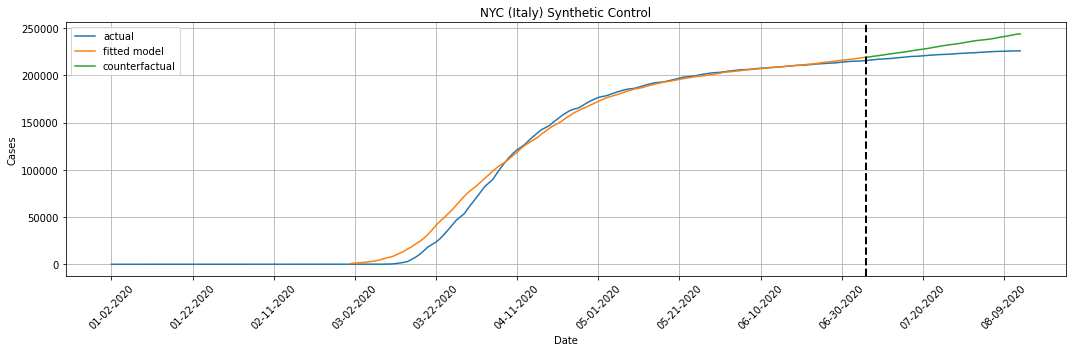

In [116]:
# So try 3 singular values and see what happens 
singvals = 2
otherArray = list(train2.columns)
otherArray.remove("NYC")
rmodel = RobustSyntheticControl("NYC", singvals, len(train2), probObservation = 1.0,
                modelType = 'svd', svdMethod = 'numpy', otherSeriesKeysArray = otherArray)
rmodel.fit(train2)
#Not quite sure what this does but it seems important
denoisedDF = rmodel.model.denoisedDF()

#multiply by modeled weights to get predictions
predictions = []
predictions = np.dot(test2[otherArray], rmodel.model.weights)
predictions = pd.Series(predictions, index = test.index)
#get actual results

actual = nyc_others.NYC

#fit the model on the training data to see how accurate it is
model_fit = np.dot(train2[otherArray], rmodel.model.weights)
model_fit = pd.Series(model_fit, index = train.index)

# and graph to see results
plot_synth(actual, model_fit, predictions, "NYC Synthetic Control", "Cases")

hide_toggle()

And, also interesting is the fact that removing the data from Italy results in a model that doesn't fit the actual curve very well, but does show that New York is doing much better than the other states its being compared to (Again depending on how many singular values are used). Here is the same model without Italy:

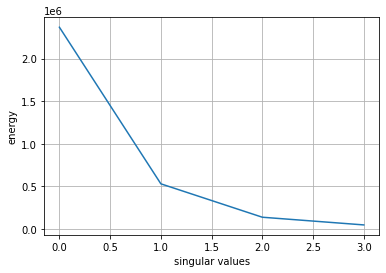

In [121]:
noitaly_train = train2.drop("Italy", axis = 1)
noitaly_test = test2.drop("Italy", axis = 1)
check_vals(noitaly_train)

hide_toggle()

3 Singular Values: (Note that you get similar results for 1 and 4)

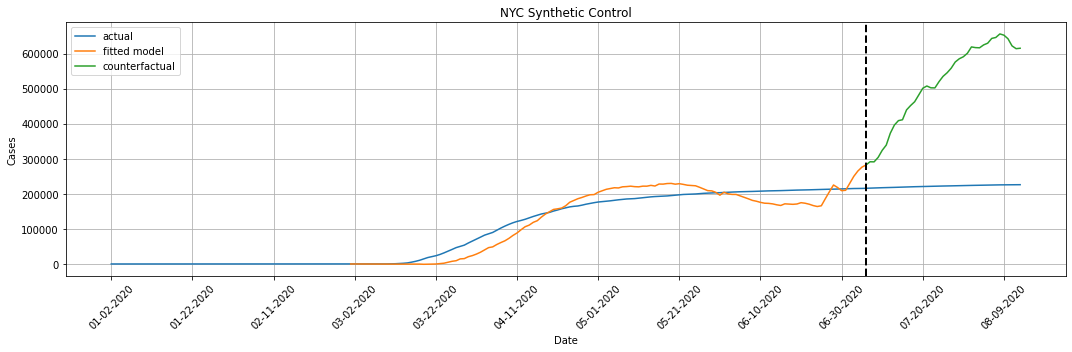

In [122]:
# So try 3 singular values and see what happens 
singvals = 3
otherArray = list(noitaly_train.columns)
otherArray.remove("NYC")
rmodel = RobustSyntheticControl("NYC", singvals, len(noitaly_train), probObservation = 1.0,
                modelType = 'svd', svdMethod = 'numpy', otherSeriesKeysArray = otherArray)
rmodel.fit(noitaly_train)
#Not quite sure what this does but it seems important
denoisedDF = rmodel.model.denoisedDF()

#multiply by modeled weights to get predictions
predictions = []
predictions = np.dot(noitaly_test[otherArray], rmodel.model.weights)
predictions = pd.Series(predictions, index = test.index)
#get actual results

actual = nyc_others.NYC

#fit the model on the training data to see how accurate it is
model_fit = np.dot(noitaly_train[otherArray], rmodel.model.weights)
model_fit = pd.Series(model_fit, index = train.index)

# and graph to see results
plot_synth(actual, model_fit, predictions, "NYC Synthetic Control", "Cases")

hide_toggle()

2 Singular Values:

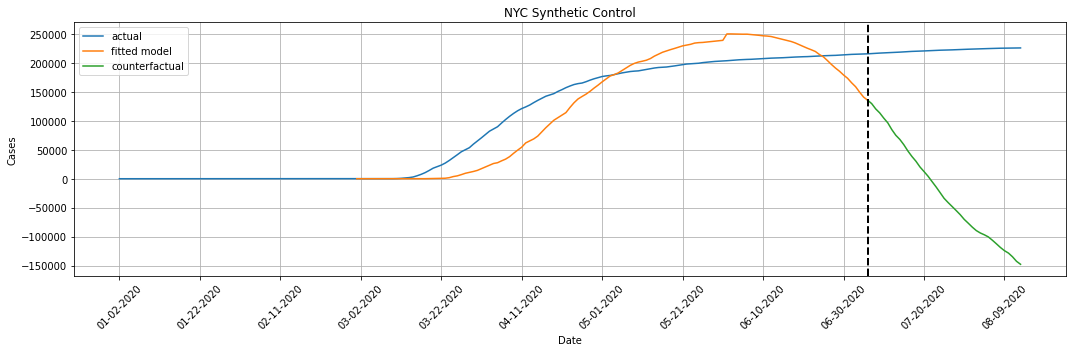

In [123]:
# So try 3 singular values and see what happens 
singvals = 2
otherArray = list(noitaly_train.columns)
otherArray.remove("NYC")
rmodel = RobustSyntheticControl("NYC", singvals, len(noitaly_train), probObservation = 1.0,
                modelType = 'svd', svdMethod = 'numpy', otherSeriesKeysArray = otherArray)
rmodel.fit(noitaly_train)
#Not quite sure what this does but it seems important
denoisedDF = rmodel.model.denoisedDF()

#multiply by modeled weights to get predictions
predictions = []
predictions = np.dot(noitaly_test[otherArray], rmodel.model.weights)
predictions = pd.Series(predictions, index = test.index)
#get actual results

actual = nyc_others.NYC

#fit the model on the training data to see how accurate it is
model_fit = np.dot(noitaly_train[otherArray], rmodel.model.weights)
model_fit = pd.Series(model_fit, index = train.index)

# and graph to see results
plot_synth(actual, model_fit, predictions, "NYC Synthetic Control", "Cases")

hide_toggle()

## Conclusions

What all of this tells me is that the Synthetic control model is very picky. It needs carefully selected data to produce meaningful results. In this example it needed Italy to better fit the model. Although, the results without Italy may be interesting on their own. I think it is definitely important to play around with the singular values and find what works best. A better understanding of the data and where it comes from might have been helped determine why changing the singular values changed the model